In [26]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [27]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [28]:
NUM_CLASSES = 30

In [29]:
NUM_CLASSES = 30

# Dataset reading

In [30]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [31]:
NUM_CLASSES = 30

In [32]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [34]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (13301, 42)
y_train shape: (13301,)
X_test shape: (4434, 42)
y_test shape: (4434,)


# Model building

In [35]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )), # had to change for the two handed gestures
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [36]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_2 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,400 (5.47 KB)

 Trainable params: 1,400 (5.47 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [38]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [39]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 55/104 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.0405 - loss: 3.5179 
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0428 - loss: 3.4831 - val_accuracy: 0.1306 - val_loss: 3.3626
Epoch 2/1000
 67/104 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.0587 - loss: 3.3596
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0618 - loss: 3.3525 - val_accuracy: 0.1430 - val_loss: 3.2635
Epoch 3/1000
 64/104 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.0849 - loss: 3.2652
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0866 - loss: 3.2546 - val_accuracy: 0.1430 - val_loss: 3.1053
Epoch 4/1000
 63/104 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.1054 - loss: 3.1426
Epoch 4: saving model to model/keypoint_classifier/keypoi

In [40]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6328 - loss: 1.4563

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.6262 - loss: 1.4518


In [41]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [42]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[2.8327062e-07 2.0203352e-02 6.1919302e-04 1.5923670e-11 6.1988899e-06
 3.7609587e-07 5.5557216e-06 1.5604903e-05 8.6096668e-07 1.9338719e-07
 2.9735649e-02 7.8741599e-05 1.2020994e-06 1.8280047e-03 6.4442236e-07
 3.9764445e-06 4.8218849e-03 1.5568855e-02 1.2158329e-03 1.1204446e-01
 1.1349837e-03 1.1077432e-05 1.8772040e-04 1.0012224e-03 1.3658949e-03
 1.9098115e-05 1.2990797e-03 8.4765709e-04 3.3114670e-04 8.0765122e-01]
29


# Confusion matrix

  1/139 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step


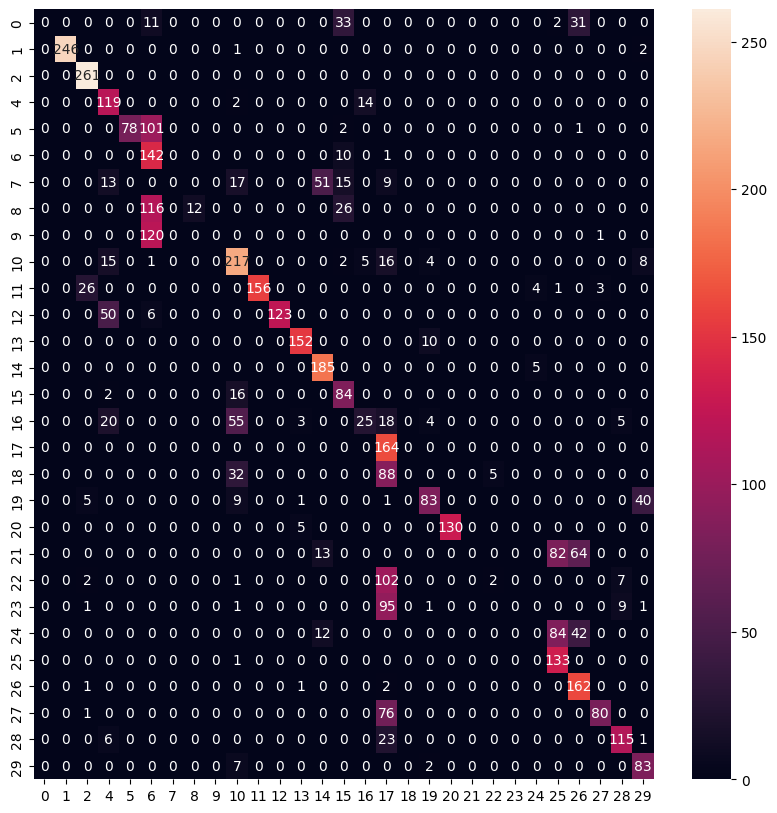

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       1.00      0.99      0.99       249
           2       0.88      1.00      0.94       261
           4       0.53      0.88      0.66       135
           5       1.00      0.43      0.60       182
           6       0.29      0.93      0.44       153
           7       0.00      0.00      0.00       105
           8       1.00      0.08      0.14       154
           9       0.00      0.00      0.00       121
          10       0.60      0.81      0.69       268
          11       1.00      0.82      0.90       190
          12       1.00      0.69      0.81       179
          13       0.94      0.94      0.94       162
          14       0.71      0.97      0.82       190
          15       0.49      0.82      0.61       102
          16       0.57      0.19      0.29       130
          17       0.28      1.00      0.43       164
     

c:\Users\horizontal\Documents\GitHub\csci218-group-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\horizontal\Documents\GitHub\csci218-group-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\horizontal\Documents\GitHub\csci218-group-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [44]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [45]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\HORIZO~1\AppData\Local\Temp\tmpl_brbzow\assets


INFO:tensorflow:Assets written to: C:\Users\HORIZO~1\AppData\Local\Temp\tmpl_brbzow\assets


Saved artifact at 'C:\Users\HORIZO~1\AppData\Local\Temp\tmpl_brbzow'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 30), dtype=tf.float32, name=None)
Captures:
  2571740243600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2571740239568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2571740244752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2571740242448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2571740246288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2571740243024: TensorSpec(shape=(), dtype=tf.resource, name=None)


7684

# Inference test

In [46]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [47]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [48]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [49]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [50]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.83270424e-07 2.02033315e-02 6.19192608e-04 1.59236756e-11
 6.19887942e-06 3.76095613e-07 5.55571751e-06 1.56048918e-05
 8.60965258e-07 1.93387066e-07 2.97356155e-02 7.87415484e-05
 1.20209734e-06 1.82800263e-03 6.44421277e-07 3.97644180e-06
 4.82187932e-03 1.55688375e-02 1.21583138e-03 1.12044327e-01
 1.13498233e-03 1.10774135e-05 1.87720099e-04 1.00122159e-03
 1.36589329e-03 1.90980827e-05 1.29907764e-03 8.47656105e-04
 3.31146148e-04 8.07651460e-01]
29
